### Exploratory Data Analysis of Criteo Attribution Dataset

This dataset represents a sample of 30 days of Criteo live traffic data. Each line corresponds to one impression (a banner) that was displayed to a user. For each banner we have detailed information about the context, if it was clicked, if it led to a conversion and if it led to a conversion that was attributed to Criteo or not.

- Timestamp: timestamp of the impression
- UID: unique user identifier
- Campaign: unique campaign identifier
- Conversion: 1 if there was a conversion in the 30 days after the impression; 0 otherwise
- Conversion ID: a unique identifier for each conversion
- Click: 1 if the impression was clicked; 0 otherwise
- Cost: the price paid for this ad
- Cat1-Cat9: categorical features associated with the ad. These features’ semantic meaning is not disclosed.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import os

from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

import keras

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

In [3]:
os.chdir(r'N:\ALGORITHMIC MARKETING\Assignment3\criteo_attribution_dataset')

In [92]:
DATA_FILE='criteo_attribution_dataset.tsv.gz'
df_Criteo_Attribution = pd.read_csv(DATA_FILE, sep='\t', compression='gzip')

The timeline consists of Timestamp column, lets convert them to Days. 

In [93]:
df_Criteo_Attribution['day'] = np.floor(df_Criteo_Attribution.timestamp / 86400.).astype(int)
df_Criteo_Attribution['conversion_day'] = np.floor(df_Criteo_Attribution.conversion_timestamp / 86400.).astype(int)

In [94]:
df_Criteo_Attribution['jid'] = df_Criteo_Attribution['uid'].map(str) + '_' + df_Criteo_Attribution['conversion_id'].map(str)

In [7]:
df_Criteo_Attribution.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat3,cat4,cat5,cat6,cat7,cat8,cat9,day,conversion_day,jid
0,0,20073966,22589171,0,-1,-1,0,0,-1,-1,...,3490278,29196072,11409686,1973606,25162884,29196072,29196072,0,-1,20073966_-1
1,2,24607497,884761,0,-1,-1,0,0,-1,-1,...,14584482,29196072,11409686,1973606,22644417,9312274,21091111,0,-1,24607497_-1
2,2,28474333,18975823,0,-1,-1,0,0,-1,-1,...,10769841,29196072,5824237,138937,1795451,29196072,15351056,0,-1,28474333_-1
3,3,7306395,29427842,1,1449193,3063962,0,1,0,7,...,12435261,23549932,5824237,1973606,9180723,29841067,29196072,0,16,7306395_3063962
4,3,25357769,13365547,0,-1,-1,0,0,-1,-1,...,31616034,29196072,11409684,26597096,4480345,29196072,29196072,0,-1,25357769_-1


In [8]:
df_Criteo_Attribution.shape

(16468027, 25)

In [9]:
df_Criteo_Attribution.describe()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,day,conversion_day
count,1.646803e+07,1.646803e+07,1.646803e+07,1.646803e+07,1.646803e+07,1.646803e+07,1.646803e+07,1.646803e+07,1.646803e+07,1.646803e+07,...,1.646803e+07,1.646803e+07,1.646803e+07,1.646803e+07,1.646803e+07,1.646803e+07,1.646803e+07,1.646803e+07,1.646803e+07,1.646803e+07
mean,1.315440e+06,1.623759e+07,1.698396e+07,4.895523e-02,9.494022e+04,7.938852e+05,2.686563e-02,3.611582e-01,-8.312659e-01,-6.626017e-01,...,1.468723e+07,1.523307e+07,2.856511e+07,1.933946e+07,1.509511e+07,1.523342e+07,2.481559e+07,2.377115e+07,1.463595e+01,1.195004e-01
std,7.697701e+05,9.373752e+06,9.700053e+06,2.157745e-01,4.789667e+05,4.064784e+06,1.616907e-01,4.803363e-01,1.532221e+00,2.696254e+00,...,9.122112e+06,9.847417e+06,2.698653e+06,1.174612e+07,1.340641e+07,9.002238e+06,8.254685e+06,7.778015e+06,8.914175e+00,5.624486e+00
min,0.000000e+00,1.300000e+01,7.332200e+04,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,...,1.389370e+05,5.770000e+02,3.582490e+05,1.389370e+05,1.389370e+05,1.500000e+02,3.225256e+06,3.582460e+05,0.000000e+00,-1.000000e+00
25%,6.428550e+05,8.118035e+06,8.892341e+06,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,...,9.312274e+06,6.248965e+06,2.919607e+07,5.824239e+06,1.973606e+06,9.312274e+06,2.399811e+07,1.829188e+07,7.000000e+00,-1.000000e+00
50%,1.283518e+06,1.623691e+07,1.556893e+07,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,...,9.312274e+06,1.377899e+07,2.919607e+07,2.161141e+07,5.824235e+06,1.358029e+07,2.919607e+07,2.919607e+07,1.400000e+01,-1.000000e+00
75%,1.965979e+06,2.435890e+07,2.685234e+07,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,1.000000e+00,-1.000000e+00,-1.000000e+00,...,2.659710e+07,2.431043e+07,2.919607e+07,3.244004e+07,2.919607e+07,2.267415e+07,2.919607e+07,2.919607e+07,2.200000e+01,-1.000000e+00
max,2.671199e+06,3.245875e+07,3.245211e+07,1.000000e+00,5.262888e+06,3.245852e+07,1.000000e+00,1.000000e+00,1.730000e+02,1.740000e+02,...,3.244005e+07,3.245799e+07,3.214548e+07,3.244005e+07,3.244005e+07,3.245847e+07,3.244004e+07,3.214548e+07,3.000000e+01,6.000000e+01


In [10]:
df_Criteo_Attribution.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16468027 entries, 0 to 16468026
Data columns (total 25 columns):
timestamp                int64
uid                      int64
campaign                 int64
conversion               int64
conversion_timestamp     int64
conversion_id            int64
attribution              int64
click                    int64
click_pos                int64
click_nb                 int64
cost                     float64
cpo                      float64
time_since_last_click    int64
cat1                     int64
cat2                     int64
cat3                     int64
cat4                     int64
cat5                     int64
cat6                     int64
cat7                     int64
cat8                     int64
cat9                     int64
day                      int32
conversion_day           int32
jid                      object
dtypes: float64(2), int32(2), int64(20), object(1)
memory usage: 2.9+ GB


In [95]:
df_Criteo_Attribution['gap_click_sale'] = -1
df_Criteo_Attribution.loc[df_Criteo_Attribution.conversion == 1, 'gap_click_sale'] = df_Criteo_Attribution.conversion_day - df_Criteo_Attribution.day

#### Journey Length for all 

In [96]:
# min touchpoints = 2
grouped = df_Criteo_Attribution.groupby(['jid'])['uid'].count().reset_index(name="count")
df_Criteo_Attribution = df_Criteo_Attribution[df_Criteo_Attribution['jid'].isin( grouped[grouped['count'] >= 2]['jid'].values )]

In [13]:
df_Criteo_Attribution.groupby(['jid'])['uid'].count().reset_index(name="count").groupby(['count']).count()

,jid
count,
2,1255247
3,612915
4,350059
5,219282
6,146473
...,...
327,1
365,1
478,1


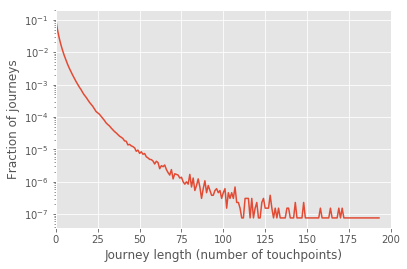

In [14]:
def journey_length_histogram(df):
    counts = df.groupby(['jid'])['uid'].count().reset_index(name="count").groupby(['count']).count()
    return counts.index, counts.values / df.shape[0]

hist_x, hist_y = journey_length_histogram(df_Criteo_Attribution)

plt.plot(range(len(hist_x)), hist_y, label='all journeys')
plt.yscale('log')
plt.xlim(0, 200)
plt.xlabel('Journey length (number of touchpoints)')
plt.ylabel('Fraction of journeys')
plt.show()

### Journey Length for only Journey which got converted 


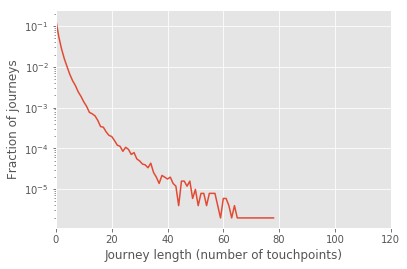

In [15]:
def journey_length_hist(df):
    counts = df.groupby(['jid'])['uid'].count().reset_index(name="count").groupby(['count']).count()
    return counts.index, counts.values / df.shape[0]

hist_x, hist_y = journey_length_hist(df_Criteo_Attribution[df_Criteo_Attribution.conversion==1])

plt.plot(range(len(hist_x)), hist_y, label='all journeys')
plt.yscale('log')
plt.xlim(0, 120)
plt.xlabel('Journey length (number of touchpoints)')
plt.ylabel('Fraction of journeys')
plt.show()

#### Events on each day,  Conversions on each day & Attribution to Criteo on Each day 

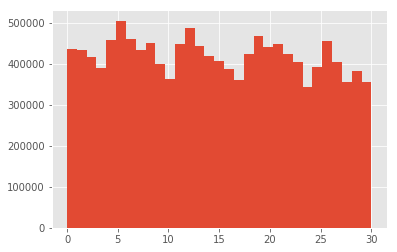

In [16]:
df_Criteo_Attribution.day.hist(bins=len(df_Criteo_Attribution.day.unique()))

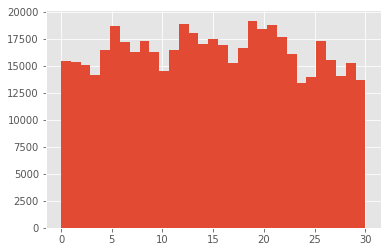

In [17]:
df_Criteo_Attribution[df_Criteo_Attribution.conversion==1].day.hist(bins=len(df_Criteo_Attribution.day.unique()))

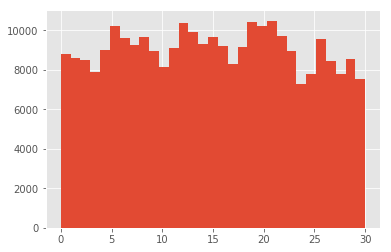

In [18]:
df_Criteo_Attribution[df_Criteo_Attribution.attribution==1].day.hist(bins=len(df_Criteo_Attribution.day.unique()))

In [19]:
df_cost = df_Criteo_Attribution.groupby(['day'])['cost'].sum().reset_index(name="Total Spending")
df_cost

,day,Total Spending
0,0,130.828292
1,1,133.236689
2,2,128.055007
3,3,118.924569
4,4,145.451227
5,5,153.176759
6,6,141.741375
7,7,137.239348
8,8,134.989205
9,9,121.958678


Text(0,0.5,'Spending')

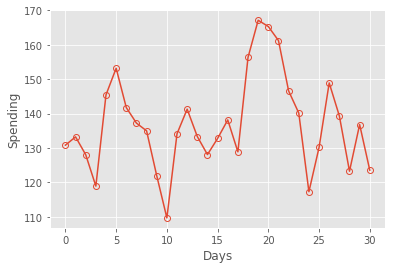

In [21]:
plt.plot(df_cost.day, df_cost['Total Spending'], linestyle='-', marker='o', fillstyle=None, 
         markerfacecolor="None")
plt.xlabel('Days')
plt.ylabel('Spending')

### Campaign wise Conversions, Attributions, Users  

In [22]:
# Conversions per campaign
df_Criteo_Conversion = df_Criteo_Attribution[df_Criteo_Attribution.conversion==1]
df_Criteo_Conversion.groupby(['campaign'])['jid'].nunique().reset_index(name="count")

,campaign,count
0,73322,8
1,73325,58
2,73327,86
3,73328,148
4,83677,72
...,...,...
667,32398755,104
668,32398758,76
669,32405311,29
670,32452108,42


In [23]:
# Attributions per campaign
df_Criteo_Conversion = df_Criteo_Attribution[df_Criteo_Attribution.conversion==1]
df_Criteo_Conversion[df_Criteo_Conversion.attribution==1].groupby(['campaign'])['jid'].nunique().reset_index(name="count")

,campaign,count
0,73322,8
1,73325,39
2,73327,72
3,73328,118
4,83677,38
...,...,...
657,32398755,26
658,32398758,28
659,32405311,24
660,32452108,14


In [24]:
# Campaign wise User Count
df_Criteo_Attribution.groupby(['campaign'])['uid'].nunique().reset_index(name="User count")

,campaign,User count
0,73322,182
1,73325,1435
2,73327,1967
3,73328,3364
4,83677,13185
...,...,...
670,32398755,5092
671,32398758,3077
672,32405311,735
673,32452108,3224


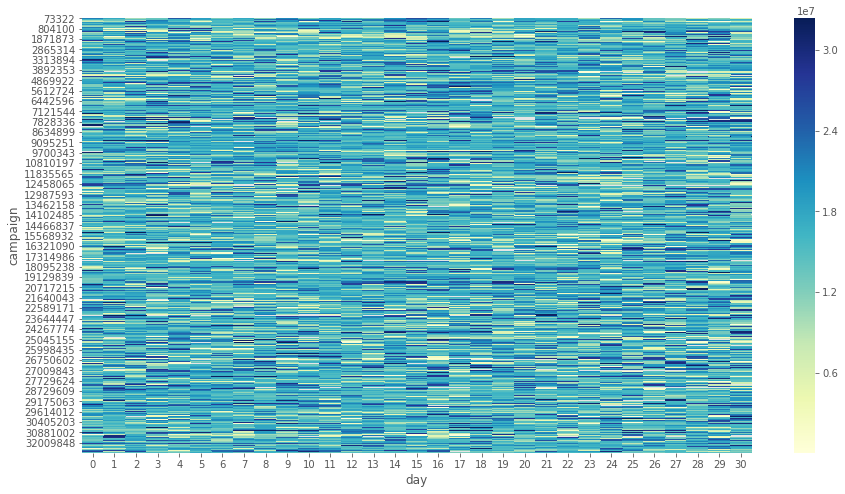

In [26]:
import seaborn as sns
df_user_camp = pd.pivot_table(df_Criteo_Conversion, values='uid', index=['campaign'], columns='day')
plt.figure(figsize=(15, 8))
sns.heatmap(df_user_camp, cmap="YlGnBu")

In [27]:
df_Criteo_Attribution[df_Criteo_Attribution.uid==26251261]

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat4,cat5,cat6,cat7,cat8,cat9,day,conversion_day,jid,gap_click_sale
497027,73538,26251261,4869922,1,481370,7432488,1,1,12,52,...,29196072,5824236,28928366,3044794,29196072,21091111,0,5,26251261_7432488,5
497308,73569,26251261,4869922,1,481370,7432488,1,1,13,52,...,29196072,5824236,28928366,3044794,29196072,358249,0,5,26251261_7432488,5
503913,74248,26251261,4869922,1,481370,7432488,1,1,14,52,...,29196072,5824236,28928366,9181506,29196072,6083947,0,5,26251261_7432488,5
646942,115042,26251261,4869922,1,481370,7432488,1,1,15,52,...,29196072,5824236,28928366,9181506,29196072,9491354,1,5,26251261_7432488,4
1421561,228347,26251261,4869922,1,481370,7432488,1,1,16,52,...,29196072,5824236,28928366,9181506,29196072,29520626,2,5,26251261_7432488,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15843238,2566880,26251261,4869922,1,2899600,22997480,1,1,18,38,...,17152695,5824236,3808271,20574082,29196072,6755486,29,33,26251261_22997480,4
15843317,2566892,26251261,4869922,1,2899600,22997480,1,1,19,38,...,17152695,5824236,3808271,20574082,29196072,6755489,29,33,26251261_22997480,4
15847110,2567382,26251261,4869922,1,2899600,22997480,1,1,20,38,...,17152695,5824236,3808271,20574082,29196072,6083952,29,33,26251261_22997480,4
15847914,2567481,26251261,4869922,1,2899600,22997480,1,1,21,38,...,17152695,5824236,3808271,1437331,29196072,22419790,29,33,26251261_22997480,4


### Journey Analysis

It seems like in a Journey we have only one campaign associated with each User. lets verify that from the data. 

In [28]:
df_journey = df_Criteo_Conversion.groupby(['jid'])['campaign'].unique().reset_index(name="Campaigns")
df_journey.head(10)

,jid,Campaigns
0,1000023_5282678,[10341182]
1,10000403_29178244,[15398570]
2,10000523_19113736,[3466867]
3,10000523_2559380,[3466867]
4,10000953_28271511,[11835565]
5,1000095_27795443,[15398570]
6,10001378_24057324,[15746419]
7,10001676_25144611,[3828360]
8,1000171_30068510,[29427842]
9,10002223_13942262,[11097337]


In [29]:
def calc(camp):
    return len(camp)

df_journey['Camp_count'] = df_journey.apply(lambda val: calc(val.Campaigns),axis=1)
df_journey

,jid,Campaigns,Camp_count
0,1000023_5282678,[10341182],1
1,10000403_29178244,[15398570],1
2,10000523_19113736,[3466867],1
3,10000523_2559380,[3466867],1
4,10000953_28271511,[11835565],1
...,...,...,...
139757,9999223_11861724,[25391297],1
139758,9999669_4594367,[21294794],1
139759,9999681_20315908,[12843316],1
139760,9999748_25873601,[15184511],1


In [30]:

df_journey[~df_journey.Camp_count.eq(1)]

,jid,Campaigns,Camp_count


In [133]:
#df_Criteo_Conversion.groupby(['jid'])['campaign'].nunique().reset_index(name="C_count")

#### Journies per Campaign where the Journey led to conversion

In [31]:
df_Criteo_Conversion.groupby(['campaign'])['jid'].nunique().reset_index(name="Journey_count")

,campaign,Journey_count
0,73322,8
1,73325,58
2,73327,86
3,73328,148
4,83677,72
...,...,...
667,32398755,104
668,32398758,76
669,32405311,29
670,32452108,42


Average Number of Days between a First Click and a Conversion, Grouped by Campaign

In [33]:
df_Criteo_Conversion[df_Criteo_Conversion.jid.eq('7306395_3063962')]

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat4,cat5,cat6,cat7,cat8,cat9,day,conversion_day,jid,gap_click_sale
3,3,7306395,29427842,1,1449193,3063962,0,1,0,7,...,23549932,5824237,1973606,9180723,29841067,29196072,0,16,7306395_3063962,16
2364583,391213,7306395,29427842,1,1449193,3063962,0,1,1,7,...,23549932,5824237,1973606,9180723,29841067,21091111,4,16,7306395_3063962,12
2684559,421106,7306395,29427842,1,1449193,3063962,0,1,2,7,...,23549932,5824237,1973606,9180723,23998111,9491351,4,16,7306395_3063962,12
3303920,505427,7306395,29427842,1,1449193,3063962,0,1,3,7,...,15743247,5824237,1973606,16561097,3225256,29520629,5,16,7306395_3063962,11
5561827,858727,7306395,29427842,1,1449193,3063962,0,1,4,7,...,29196072,5824237,1973606,16561097,29841067,21091111,9,16,7306395_3063962,7
7370651,1160081,7306395,29427842,1,1449193,3063962,0,1,5,7,...,29196072,5824237,1973606,16561097,29841067,21091111,13,16,7306395_3063962,3
8801039,1380702,7306395,29427842,1,1449193,3063962,0,1,6,7,...,29196072,5824237,1973606,18079314,29841067,21091108,15,16,7306395_3063962,1


In [34]:
# taking only the ones where the click position is 0 means it is first click. 

df_click_gap = df_Criteo_Conversion[df_Criteo_Conversion.click_pos==0]
df_click_gap.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat4,cat5,cat6,cat7,cat8,cat9,day,conversion_day,jid,gap_click_sale
3,3,7306395,29427842,1,1449193,3063962,0,1,0,7,...,23549932,5824237,1973606,9180723,29841067,29196072,0,16,7306395_3063962,16
180,101,3208958,28739284,1,2469937,20579181,0,1,0,2,...,29196072,32440044,5824239,15154549,29196072,18291877,0,28,3208958_20579181,28
293,174,15086999,15184511,1,427902,76235,1,1,0,3,...,17152695,5824235,1973606,32081193,29841067,29520629,0,4,15086999_76235,4
419,244,16502720,23817046,1,257000,13682746,1,1,0,3,...,17152695,5824237,28928366,10577371,29196072,21091108,0,2,16502720_13682746,2
430,253,12693061,25064375,1,504933,16298248,0,1,0,2,...,29196072,32440044,1973606,25944640,23998111,29196072,0,5,12693061_16298248,5


In [37]:
#df_click_gap[df_click_gap.campaign.eq(29427842)]

In [56]:
df_click_gap_sale = df_click_gap.groupby(['campaign'])['gap_click_sale'].mean().reset_index(name="Gap_click_sale").sort_values(by='Gap_click_sale')
df_click_gap_sale

,campaign,Gap_click_sale
332,15500296,0.000000
389,18496278,0.000000
331,15500294,1.000000
570,28233117,1.333333
527,26750599,2.250000
...,...,...
405,19860994,18.250000
89,4626334,19.100000
81,3892354,19.400000
283,13442456,20.000000


In [57]:
df_click_gap_sale1 = df_click_gap_sale[620:]

Text(0,0.5,'Campaign')

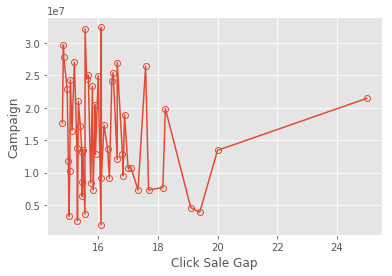

In [58]:

plt.plot(df_click_gap_sale1['Gap_click_sale'],df_click_gap_sale1.campaign, linestyle='-', marker='o', fillstyle=None, 
         markerfacecolor="None")
plt.xlabel('Click Sale Gap')
plt.ylabel('Campaign')

Text(0,0.5,'Campaign')

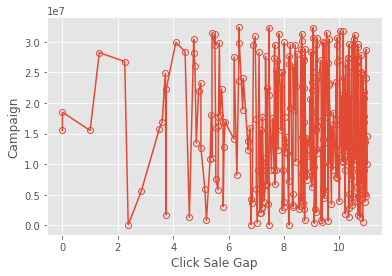

In [70]:
df_click_gap_sale2 = df_click_gap_sale[:300]

plt.plot(df_click_gap_sale2['Gap_click_sale'],df_click_gap_sale2.campaign, linestyle='-', marker='o', fillstyle=None, 
         markerfacecolor="None")
plt.xlabel('Click Sale Gap')
plt.ylabel('Campaign')

Most of the Campaigns have 5-10 days between the first click and Conversion

Implementing LTA and FTA using Click information instead of timestamp

In [97]:
n_campaigns = 400
np.random.seed(42)

def sample_campaigns(df, n_campaigns):    
    campaigns = np.random.choice( df['campaign'].unique(), n_campaigns, replace = False )
    return df[ df['campaign'].isin(campaigns) ]

    
def balance_conversions(df):
    df_minority = df[df.conversion == 1]
    df_majority = df[df.conversion == 0]
    
    df_majority_jids = np.array_split(df_majority['jid'].unique(), 100 * df_majority.shape[0]/df_minority.shape[0] )
    
    df_majority_sampled = pd.DataFrame(data=None, columns=df.columns)
    for jid_chunk in df_majority_jids:
        df_majority_sampled = pd.concat([df_majority_sampled, df_majority[df_majority.jid.isin(jid_chunk)]])
        if df_majority_sampled.shape[0] > df_minority.shape[0]:
            break
    
    return pd.concat([df_majority_sampled, df_minority]).sample(frac=1).reset_index(drop=True)



def map_one_hot(df, column_names, result_column_name):
    mapper = {} 
    for i, col_name in enumerate(column_names):
        for val in df[col_name].unique():
            mapper[str(val) + str(i)] = len(mapper)
         
    df_ext = df.copy()
    
    def one_hot(values):
        v = np.zeros( len(mapper) )
        for i, val in enumerate(values): 
            v[ mapper[str(val) + str(i)] ] = 1
        return v    
    
    df_ext[result_column_name] = df_ext[column_names].values.tolist()
    df_ext[result_column_name] = df_ext[result_column_name].map(one_hot)
    
    return df_ext


def add_derived_columns(df):
    df_ext = df.copy()
    #df_ext['jid'] = df_ext['uid'].map(str) + '_' + df_ext['conversion_id'].map(str)
    
    min_max_scaler = MinMaxScaler()
    for cname in ('timestamp', 'time_since_last_click'):
        x = df_ext[cname].values.reshape(-1, 1) 
        df_ext[cname + '_norm'] = min_max_scaler.fit_transform(x)
    
    return df_ext


In [98]:
df_Criteo_Attribution = add_derived_columns(df_Criteo_Attribution)

df_Criteo_Attribution = sample_campaigns(df_Criteo_Attribution, n_campaigns)

df_Criteo_Attribution = balance_conversions(df_Criteo_Attribution)

df_Criteo_Attribution = map_one_hot(df_Criteo_Attribution, ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8'], 'cats')

df_Criteo_Attribution = map_one_hot(df_Criteo_Attribution, ['campaign'], 'campaigns').sort_values(by=['timestamp_norm'])

C:\Users\nikhi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\nikhi\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [71]:
df_Criteo_Conve = df_Criteo_Conversion

df_Criteo_Conve['last_click'] = df_Criteo_Conve.conversion * (df_Criteo_Conve.click_pos == df_Criteo_Conve.click_nb - 1).astype(int)
df_Criteo_Conve.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat5,cat6,cat7,cat8,cat9,day,conversion_day,jid,gap_click_sale,last_click
3,3,7306395,29427842,1,1449193,3063962,0,1,0,7,...,5824237,1973606,9180723,29841067,29196072,0,16,7306395_3063962,16,0
44,25,6013772,15184511,1,138469,15587012,0,1,1,6,...,5824235,32440044,32081193,29196072,6083952,0,1,6013772_15587012,1,0
52,30,9451380,17321082,1,355909,4136014,0,1,1,3,...,5824237,30763035,7230114,29196072,21091111,0,4,9451380_4136014,4,0
166,93,2380977,32368244,1,1471679,28647208,0,1,5,8,...,11409684,30763035,30328882,29196072,29520626,0,17,2380977_28647208,17,0
180,101,3208958,28739284,1,2469937,20579181,0,1,0,2,...,32440044,5824239,15154549,29196072,18291877,0,28,3208958_20579181,28,0


In [99]:
df_Criteo_Attribution.columns   #26

Index(['timestamp', 'uid', 'campaign', 'conversion', 'conversion_timestamp',
       'conversion_id', 'attribution', 'click', 'click_pos', 'click_nb',
       'cost', 'cpo', 'time_since_last_click', 'cat1', 'cat2', 'cat3', 'cat4',
       'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'day', 'conversion_day', 'jid',
       'gap_click_sale', 'timestamp_norm', 'time_since_last_click_norm',
       'cats', 'campaigns'],
      dtype='object')

In [100]:
df_Criteo_Attribution.shape

(659902, 30)

In [102]:
def LTA(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    #df_converted['linear'] = df_converted.conversion / (df_converted.click_nb).astype(float)
    df_converted['last_click'] = df_converted.conversion * (df.click_pos == df.click_nb - 1).astype(int)
    
    def LTA_by_campaign(df_conv):
        counters = np.zeros(n_campaigns)
        for idx in range(len(df_conv)):
            campaign_id = np.argmax(df_conv.iloc[idx, 29])
            counters[campaign_id] = counters[campaign_id] + df_conv.iloc[idx, 30]
        
        return counters
    
    campaign_conversions = LTA_by_campaign(df_converted)
    
    return campaign_conversions / campaign_impressions
    
lta = LTA(df_Criteo_Attribution)

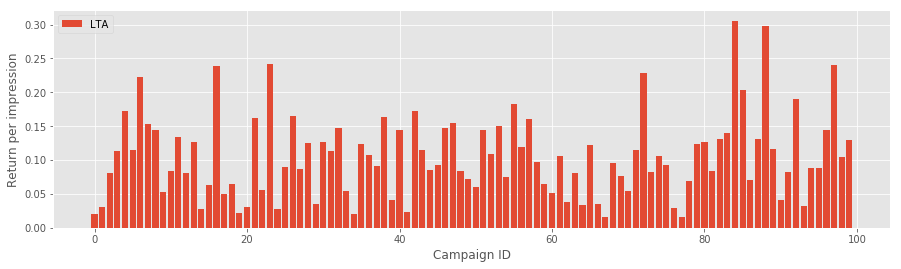

In [103]:
# Visualization of the attribution scores

campaign_idx = range(150, 250)

fig = plt.figure(figsize=(15,4))
#ax = fig.add_subplot(111)
plt.bar( range(len(lta[campaign_idx])), lta[campaign_idx], label='LTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [104]:
def FTA(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    #df_converted['linear'] = df_converted.conversion / (df_converted.click_nb).astype(float)
    df_converted['first_click'] = df_converted.conversion * (df.click_pos == 0).astype(int)
    
    def FTA_by_campaign(df_conv):
        counters = np.zeros(n_campaigns)
        for idx in range(len(df_conv)):
            campaign_id = np.argmax(df_conv.iloc[idx, 29])
            counters[campaign_id] = counters[campaign_id] + df_conv.iloc[idx, 30]
        
        return counters
    
    campaign_conversions = FTA_by_campaign(df_converted)
    
    return campaign_conversions / campaign_impressions

fta = FTA(df_Criteo_Attribution)

In [105]:
fta

array([0.21768061, 0.08390916, 0.16176471, 0.04409538, 0.11658758,
       0.1416185 , 0.05569701, 0.11265635, 0.25301764, 0.11290323,
       0.21990783, 0.08786611, 0.13785373, 0.08243728, 0.0942623 ,
       0.04      , 0.04605343, 0.05812179, 0.06218487, 0.09816176,
       0.09429009, 0.13389121, 0.12674484, 0.05106224, 0.11545151,
       0.07964602, 0.09058535, 0.09452137, 0.08176101, 0.11357022,
       0.22916811, 0.08851675, 0.07971746, 0.22640118, 0.11103701,
       0.14651368, 0.08919271, 0.03205128, 0.21992504, 0.05928774,
       0.05063472, 0.12842713, 0.03797468, 0.11934511, 0.08951965,
       0.08358571, 0.12044323, 0.0415657 , 0.10470085, 0.14970607,
       0.29916025, 0.06510851, 0.09954158, 0.11522634, 0.04491803,
       0.14262778, 0.02873563, 0.05532359, 0.06690998, 0.11324042,
       0.17888244, 0.12917595, 0.20785621, 0.05702993, 0.3001912 ,
       0.12646675, 0.14805361, 0.15270541, 0.13531353, 0.10062747,
       0.11955855, 0.05851064, 0.06608696, 0.15044664, 0.15824

In [106]:
lta == fta 

array([False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False,  True,
       False, False, False, False, False, False, False,  True, False,
       False, False,

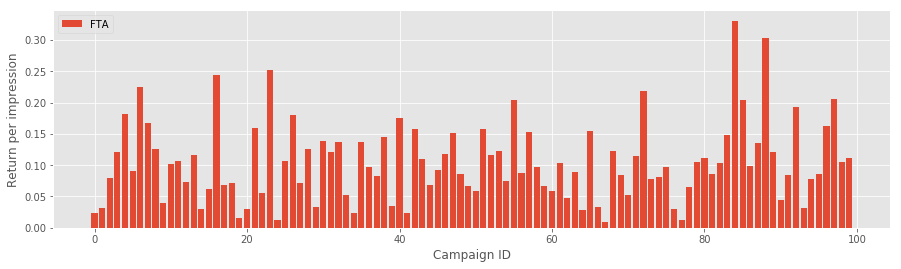

In [107]:
# Visualization of the attribution scores

campaign_idx = range(150, 250)

fig = plt.figure(figsize=(15,4))
#ax = fig.add_subplot(111)
plt.bar( range(len(fta[campaign_idx])), fta[campaign_idx], label='FTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()